# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Amanda | Choy | Amanda Choy, 4/11/2024 | 5 | 25% |
| Member 2: | Di | Su | Di Su, 4/11/2024 | 5 | 25% |
| Member 3: | Jeelkumar  | Patel | Jeelkumar Patel, 4/11/2024 | 5 | 25% |
| Member 4: | Nathaniel | Lamptey | Nathaniel Lemptey, 4/11/2024 | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

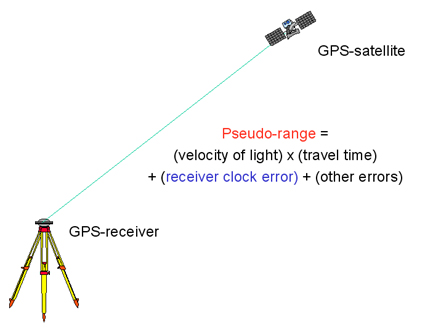

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('https://raw.github.com//jeelp97//ENGG-680-lab//main//pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('https://raw.github.com//jeelp97//ENGG-680-lab//main//satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    # Define n as the total number of observed pseudoranges
    n = pseudorange.size

    # Calculate the predicted pseudoranges for each satellite and calculate the geometric distances from the receiver to each satellite position
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges

    # Calculate sum of squared residuals and average it
    L = (1/n) * (np.sum(residuals ** 2))

    # Final cost value L - represents the average error between observed and predicted pseudoranges
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [13]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    # Define n as the total number of observed pseudoranges
    n = pseudorange.size

    # Calculate the predicted pseudoranges for each satellite and calculate the geometric distances from the receiver to each satellite position
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges

    # Initialize the gradient vector with zeros
    grad = np.zeros(4)

    # Calculate the gradients for x_r, y_r, and z_r
    x = residuals * ((r_pos[0] - s_pos[:, 0]) / predicted_pseudoranges)
    y = residuals * ((r_pos[1] - s_pos[:, 1]) / predicted_pseudoranges)
    z = residuals * ((r_pos[2] - s_pos[:, 2]) / predicted_pseudoranges)

    # Calculate the final values of each gradient component
    grad[0] = (-2 / n) * (np.sum(x))  # Gradient with respect to x_r
    grad[1] = (-2 / n) * (np.sum(y))  # Gradient with respect to y_r
    grad[2] = (-2 / n) * (np.sum(z))  # Gradient with respect to z_r
    grad[3] = (-2 / n) * (np.sum(residuals))  # Gradient with respect to cdT (clock offset)

    # Return the gradient vector
    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [14]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    # Initialize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])

    # Progress of cost, gradients, and position error at each step
    global arr_cost, arr_grad, arr_err
    arr_cost = []
    arr_grad = []
    arr_err = []

    # Begin gradient descent loop for a maximum of max_iters iterations
    for iteration in range(max_iters):

        # Extract receiver position and clock offset from the estimates
        # r_pos stores [x_r, y_r, z_r] and cdT stores the clock offset
        r_pos = X[:3]
        cdT = X[3]

        # Compute the current cost (sum of squared residuals) at the current estimates
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients (partial derivatives) of the cost function at the current estimates
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update the estimates by moving in the opposite direction of the gradient
        X_new = X - (learning_rate * grad)

        # Computer the new cost after updates
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration  # number of iterations in order to converge
            break  # stop the loop at convergence

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    # Return the final optimized estimates for x_r, y_r, z_r, and cdT
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [16]:
# Gradient_descent function with specified parameters
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6)

# Optimized parameters
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

# Final position errors of receiver
print("Final Position Errors of Receiver:", arr_err[-1])

# Numer of steps taken for convergence
print("Number of Steps Taken for Convergence:", steps_count)

# Final cost value
print("Final Cost Value:", arr_cost[-1])

# Final gradient values
print("Final Gradient Values:", arr_grad[-1])

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44842179e+00]
Final Position Errors of Receiver: [-3.06240961 -2.34633587  3.7715453 ]
Number of Steps Taken for Convergence: 2944
Final Cost Value: 0.5634452430848553
Final Gradient Values: [ 0.00015517  0.0008646  -0.00265729 -0.00150649]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

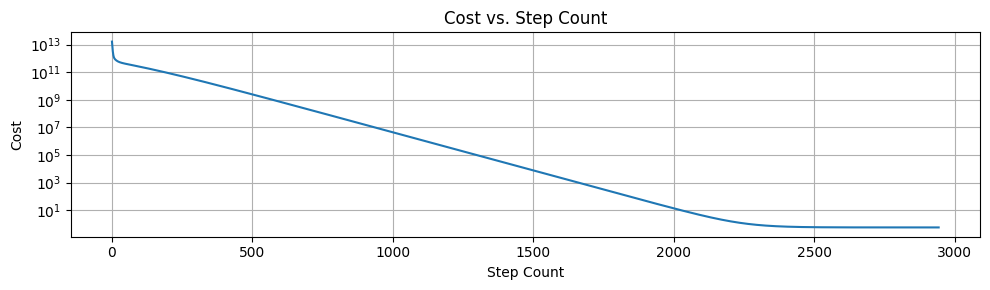

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Array representing the number of steps taken
steps_count_x = np.arange(len(arr_cost))

# Plot the cost function
plt.semilogy(steps_count_x, arr_cost)

ax.grid(True)
plt.xlabel('Step Count')
plt.ylabel('Cost')
plt.title('Cost vs. Step Count')
fig.tight_layout()
plt.show()

# The plot illustrates a steep initial decline in cost as the step count increases, representing significant improvements in optimization as step count increases.
# However, the slope tapers and cost starts to significantly decline approximately after 2000 step counts and then starts to plateau, representing the closeness and eventually to convergence.
# This pattern represents a good machine learning model achieving a optimized and successful solution.


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

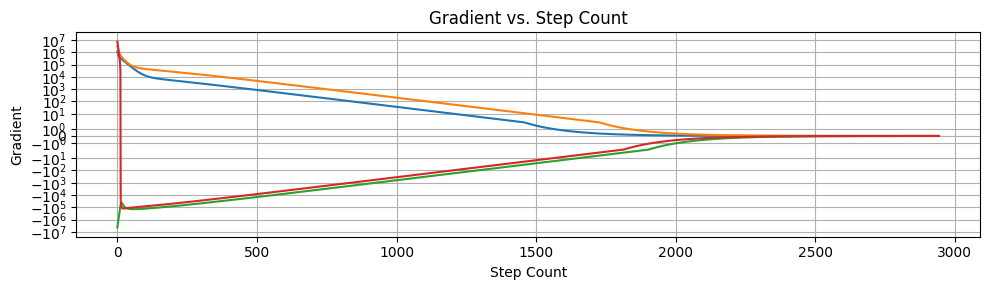

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
steps_count_x = np.arange(len(arr_grad))
plt.plot(steps_count_x, arr_grad)
plt.yscale('symlog')
ax.grid(True)
plt.xlabel('Step Count')
plt.ylabel('Gradient')
plt.title('Gradient vs. Step Count')
fig.tight_layout()
plt.show()
# The pattern

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

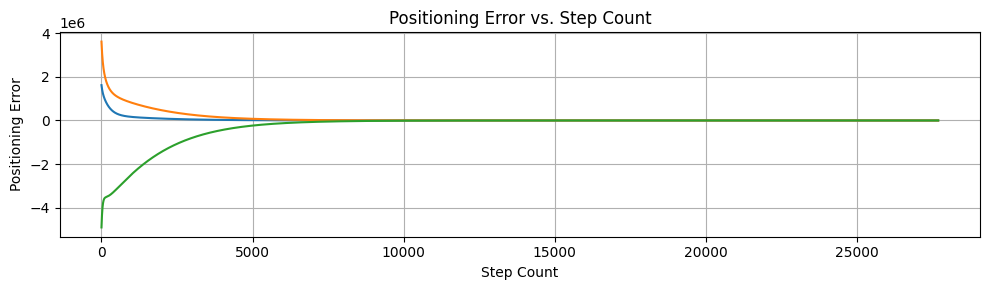

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
steps_count_x = np.arange(len(arr_err))
plt.plot(steps_count_x, arr_err)
ax.grid(True)
plt.xlabel('Step Count')
plt.ylabel('Positioning Error')
plt.title('Positioning Error vs. Step Count')
fig.tight_layout()
plt.show()
# The pattern

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [25]:
# set learning rate to 0.01
learning_rate = 0.01

# Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Gradient_descent function with specified parameters
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6)

# Final metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)

# Final positioning error
print("Final Position Error of the Receiver:", arr_err[-1])

# Number of steps taken to converge
print("Number of Steps Taken for Convergence:", steps_count)

# Final cost value
print("Final Cost Value:", arr_cost[-1])

# Final gradient values
print("Final Gradient Values:", arr_grad[-1])

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162950e+06  4.95248530e+06  6.39730478e+00]
Final Position Error of the Receiver: [-3.05714451 -2.3169989   3.6813805 ]
Number of Steps Taken for Convergence: 27703
Final Cost Value: 0.5641548423540386
Final Gradient Values: [ 0.00048857  0.00272229 -0.00836675 -0.00474335]


In [26]:
# set learning rate to 0.001
learning_rate = 0.001

# Re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Gradient_descent function with specified parameters
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=100000, tolerance=1e-6)

# Final metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)

# Final positioning error
print("Final Position Error of the Receiver:", arr_err[-1])

# Number of steps taken to converge
print("Number of Steps Taken for Convergence:", steps_count)

# Final cost value
print("Final Cost Value:", arr_cost[-1])

# Final gradient values
print("Final Gradient Values:", arr_grad[-1])

Optimized Parameters (x_r, y_r, z_r, cdT): [-1632908.30483557 -3648375.67675107  4942485.43104394    -5664.47557399]
Final Position Error of the Receiver: [  581.07484168  3251.50575256 -9996.18850524]
Number of Steps Taken for Convergence: 0
Final Cost Value: 4537315.373950557
Final Gradient Values: [  37.0507791   206.32612835 -634.06438984 -359.67969522]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



A1.
When the learning rate is reduced to 0.001 from 0.01, the number of steps to convergence was dramatically reduced to zero. This could be due to a very slow progress to convergence resembling a zero gradient or convergence. It could also be due to the algorithm's higher sensitivity to noise after the learning rate was reduced.

A2. LSE's method is based on a linear regression, by minimizing the sum of squared errors. Whereas Gradient Descent reiterates a cost function across step counts, in the goal of reaching convergence, where it is computed in "Number of Steps Taken for Convergence" in the above function.  The methodology for Gradient Descent includes updating parameters like the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges, in the above model.


# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
# Access feature_names directly as an attribute
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names

# Create the DataFrame
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix


# Assuming the target is a single column DataFrame or Series, access it by index
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target") # Accessing the first (and likely only) column


# TO DO: display sizes of X and y (1 mark)
print("Size of X (features):", X.shape)
print("Size of y (target):", y.shape)



Size of X (features): (11055, 30)
Size of y (target): (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 {-1: 4898, 1: 6157}


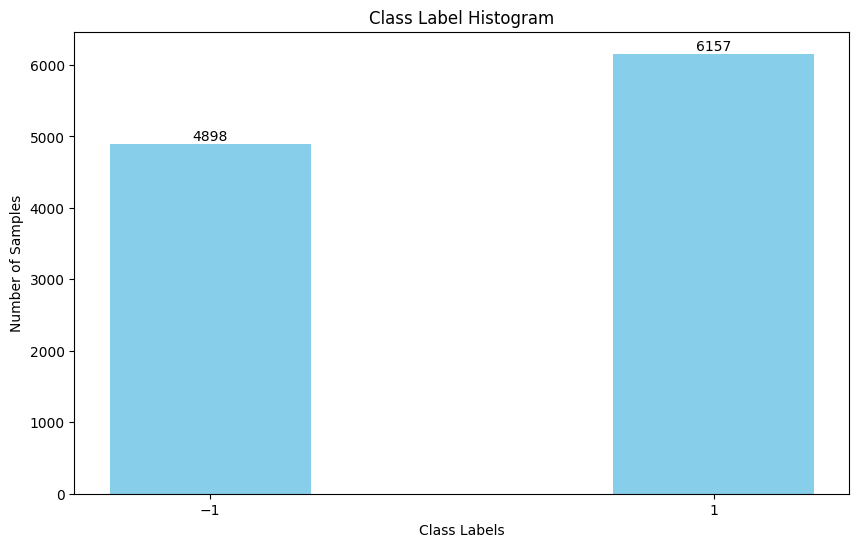

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
# Check if y is empty and handle it appropriately
if y.empty:
    print("Target variable 'y' is empty. Cannot generate class distribution.")
else:
    class_labels, counts = np.unique(y, return_counts=True)
    print("Class distribution:\n", dict(zip(class_labels, counts)))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, counts, color='skyblue')

    # Adding exact values above the bins
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval),
                 ha='center', va='bottom')  # va: vertical alignment

    # Setting title and labels
    plt.title('Class Label Histogram')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')

    # Ensure class_labels is a valid type for xticks.
    # If not numeric, cast it to a suitable type.
    if not np.issubdtype(class_labels.dtype, np.number):
        # Attempting conversion to numeric; Adjust the type if necessary
        class_labels = class_labels.astype(int)

    plt.xticks(class_labels) # Ensuring all class labels are shown


# Display exact values for each bin in the histogram

plt.show()



### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)

# Access features directly as an attribute
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names

# Create the DataFrame for features
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target")  # Target vector

# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (3% of features):", X_small.shape)
print("Size of y_small (3% of target):", y_small.shape)

Size of X_small (3% of features): (331, 30)
Size of y_small (3% of target): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

# Instantiate Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000)
# Implement the model on the full dataset (X and y)
model.fit(X, y)
print("Model trained on the full dataset (X and y)")

# Implement the model on the dataset with only the first two columns of X and y
model.fit(X.iloc[:, :2], y)
print("Model trained on the first two columns of X and y")

# Implement the model on the smaller dataset (X_small and y_small)
model.fit(X_small, y_small)
print("Model trained on the smaller dataset - 3% of data (X_small and y_small)")

Model trained on the full dataset (X and y)
Model trained on the first two columns of X and y
Model trained on the smaller dataset - 3% of data (X_small and y_small)


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target")  # Target vector

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Instantiate Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000)


# Define datasets to loop through for training and testing
datasets = [
    ("Full Dataset", X, y),
    ("First Two Columns", X.iloc[:, :2], y),
    ("Smaller Dataset", X_small, y_small)
]

# Loop through datasets and calculate required metrics
for name, X_data, y_data in datasets:
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    # Calculate log loss on the test set
    y_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_pred_proba)

    # Display results
    print(f"Results for {name}:")
    print(f"  Data Size: {X_data.shape}")
    print(f"  Number of Training Samples: {X_train.shape[0]}")
    print(f"  Number of Testing Samples: {X_test.shape[0]}")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Testing Accuracy: {test_accuracy:.4f}")
    print(f"  Log Loss: {test_log_loss:.4f}\n")


Results for Full Dataset:
  Data Size: (11055, 30)
  Number of Training Samples: 7738
  Number of Testing Samples: 3317
  Training Accuracy: 0.9311
  Testing Accuracy: 0.9219
  Log Loss: 0.1879

Results for First Two Columns:
  Data Size: (11055, 2)
  Number of Training Samples: 7738
  Number of Testing Samples: 3317
  Training Accuracy: 0.5540
  Testing Accuracy: 0.5773
  Log Loss: 0.6774

Results for Smaller Dataset:
  Data Size: (331, 30)
  Number of Training Samples: 231
  Number of Testing Samples: 100
  Training Accuracy: 0.9481
  Testing Accuracy: 0.9300
  Log Loss: 0.1923



### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information


# Function to calculate required information
def calculate_metrics(X_data, y_data):
    # Split data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

    # Instantiate and fit the Logistic Regression model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    # Calculate metrics
    data_size = X_data.shape
    training_samples = X_train.shape[0]
    testing_samples = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    testing_accuracy = accuracy_score(y_test, model.predict(X_test))
    log_loss_value = log_loss(y_test, model.predict_proba(X_test))

    return [data_size, training_samples, testing_samples, training_accuracy, testing_accuracy, log_loss_value]

# Define datasets and labels
datasets = [
    ("Full Dataset", X, y),
    ("First Two Columns", X.iloc[:, :2], y),
    ("Smaller Dataset", X_small, y_small)
]

# Create a results DataFrame
columns = ["Data Size", "Training Samples", "Testing Samples", "Training Accuracy", "Testing Accuracy", "Log Loss"]
results = pd.DataFrame(columns=columns)

# Calculate metrics for each dataset and add to results DataFrame
for name, X_data, y_data in datasets:
    metrics = calculate_metrics(X_data, y_data)
    results.loc[name] = metrics

# Print results
print("Results:\n", results)


Results:
                      Data Size  Training Samples  Testing Samples  \
Full Dataset       (11055, 30)              7738             3317   
First Two Columns   (11055, 2)              7738             3317   
Smaller Dataset      (331, 30)               231              100   

                   Training Accuracy  Testing Accuracy  Log Loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Smaller Dataset             0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)
data = phishing_websites.data.features
feature_names = phishing_websites.feature_names
df = pd.DataFrame(data, columns=feature_names)
X = df  # Feature matrix
y = pd.Series(phishing_websites.data.targets.iloc[:, 0], name="target") # Target vector

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate and train the Logistic Regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Retrieve predicted values for the testing set
y_pred = model.predict(X_test)

# Print the dimension of the predicted output
print("Dimensions of the predicted output:", y_pred.shape)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Dimensions of the predicted output: (3317,)
Confusion Matrix:
 [[1341  157]
 [  99 1720]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



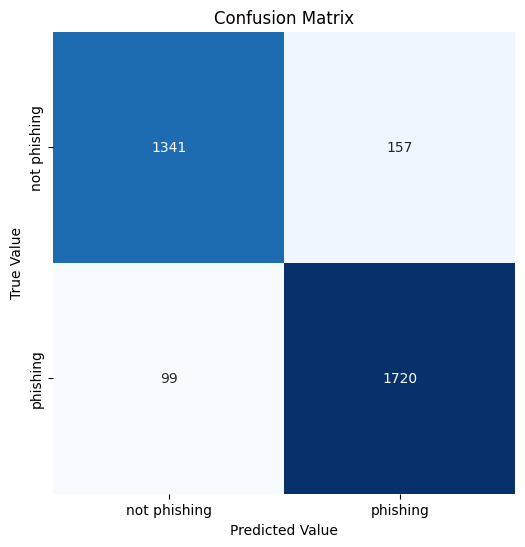

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print and visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['not phishing', 'phishing'],
            yticklabels=['not phishing', 'phishing'],
            square=True, cbar=False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print the classification report
class_report = classification_report(y_test, y_pred, target_names=['not phishing', 'phishing'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [ ]:
#Answers
#1. Yes the dataset is imbalanced as there are more phishing websites compared to non-phishing websites. It may impact model performance by allowing bias towards the majority class, although the impact may be small and minimal.
#2.
#3.
#4.
#5.
#6.